# Requirements embedding evaluation (315 repositories / train set)

## 1. Loading repository information

In [1]:
!pip install gdown
!gdown 1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756

Downloading...
From: https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756
To: /content/repo_info_train.pkl
100% 201M/201M [00:07<00:00, 28.8MB/s]


In [2]:
import pickle

with open("repo_info_train.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [3]:
!pip3 install torch
!pip3 install transformers
!pip3 install sentence-transformers
!wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
# !curl -O https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=561a6c95d967541faf6d774958cf4850b9fe39d82c0fe2bfa34897ee585722aa
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
--2023-07-04 06:49:27--  https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
Resolving raw.githubusercontent.com (raw.gith

In [4]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [5]:
unixcoder_model_names = [
    "microsoft/unixcoder-base-nine",
    "microsoft/unixcoder-base",
    "microsoft/unixcoder-base-unimodal",
    "Lazyhope/unixcoder-nine-advtest",
    "Lazyhope/unixcoder-clone-detection",
    "Enoch/Unixcoder-Tuned-Code-Search-Py"
]
sentence_transformer_model_names = [
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/multi-qa-mpnet-base-cos-v1",
    "sentence-transformers/bert-base-nli-mean-tokens",
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    "sentence-transformers/distilbert-base-nli-mean-tokens"
]
distil_bert_names = [
    "distilbert-base-uncased"
]

In [6]:
from unixcoder import UniXcoder
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, DistilBertModel

unixcoder_models = {}
sentence_transformer_models = {}
distil_bert_models = {}

# Initialise unixcoder model
for u_name in unixcoder_model_names:
    unixcoder_models[u_name] = UniXcoder(u_name)
    unixcoder_models[u_name].to(device)

# Initialise sentence transformer model
for s_name in sentence_transformer_model_names:
    sentence_transformer_models[s_name] = SentenceTransformer(model_name_or_path=s_name, device=device)

# Initialise DistilBERT model
for d_name in distil_bert_names:
    distil_bert_models[d_name] = {}
    distil_bert_models[d_name]["tokenizer"] = AutoTokenizer.from_pretrained(d_name, device=device)
    distil_bert_models[d_name]["model"] = DistilBertModel.from_pretrained(d_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 3. Generating requirements embeddings

In [9]:
# Getting requirements embeddings
def get_unixcoder_embeddings(data, model):
    tokens_ids = model.tokenize([data], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)
    return embeddings

# Getting requirements embeddings by DistilBERT
def get_bert_embeddings(data, bert_dict):
    tokenizer = bert_dict["tokenizer"]
    model = bert_dict["model"]
    inputs = tokenizer(data, padding=True, truncation=True, max_length=512, return_tensors="pt",)
    outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings

# Getting other embbeddings
def get_other_embeddings(data_list):
    embeddings = {}

    # Unixcoder model
    for u_name, u_model in tqdm(unixcoder_models.items()):
        print(f" - Using {u_name} model - ")
        embeddings_list = torch.concat([get_unixcoder_embeddings(data, u_model) for data in data_list])
        embeddings[u_name] = embeddings_list

    # Sentence transformer model
    for s_name, s_model in tqdm(sentence_transformer_models.items()):
        print(f" - Using {s_name} model - ")
        embeddings_list = s_model.encode(data_list, convert_to_tensor=True)
        embeddings[s_name] = embeddings_list

    # Using DistilBERT model
    for d_name, d_dict in tqdm(distil_bert_models.items()):
        print(f" - Using {d_name} model - ")
        embeddings_list = torch.concat([get_bert_embeddings(data, d_dict) for data in data_list])
        embeddings[d_name] = embeddings_list

    return embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)

    with torch.no_grad():
        if input_mode == "requirements":
            return get_other_embeddings(input_data)


In [10]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating requirements embeddings for {repo_name} - ")
    repo_dict["requirements_embeddings"] = get_embeddings(input_data=repo_dict["requirements"],
                                                          input_mode="requirements")

  0%|          | 0/315 [00:00<?, ?it/s]

 - Generating requirements embeddings for jet-admin/jet-bridge - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.28it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.33it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  4.23it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.20it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  4.22it/s]

100%|██████████| 6/6 [00:00<00:00, 67.85it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  0%|          | 1/315 [00:02<12:45,  2.44s/it]

 - Generating requirements embeddings for patrys/httmock - 



100%|██████████| 6/6 [00:00<00:00, 35.38it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 61.52it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  1%|          | 2/315 [00:02<06:29,  1.24s/it]

 - Generating requirements embeddings for pytransitions/transitions - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  9.46it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  8.03it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  7.46it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 40.94it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  1%|          | 3/315 [00:04<06:58,  1.34s/it]

 - Generating requirements embeddings for keleshev/schema - 



 33%|███▎      | 2/6 [00:00<00:00, 14.78it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 


100%|██████████| 6/6 [00:00<00:00, 14.67it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 




100%|██████████| 6/6 [00:00<00:00, 45.37it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  1%|▏         | 4/315 [00:05<05:53,  1.14s/it]

 - Generating requirements embeddings for dylanaraps/pywal - 



100%|██████████| 6/6 [00:00<00:00, 51.28it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 45.81it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  2%|▏         | 5/315 [00:05<04:22,  1.18it/s]

 - Using distilbert-base-uncased model - 
 - Generating requirements embeddings for PyCQA/modernize - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00, 25.82it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 24.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████▋   | 4/6 [00:00<00:00, 36.37it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 39.82it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  2%|▏         | 6/315 [00:06<03:51,  1.33it/s]

 - Generating requirements embeddings for jaraco/path.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00, 11.91it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 12.04it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 12.07it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 42.01it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  2%|▏         | 7/315 [00:06<04:06,  1.25it/s]

 - Generating requirements embeddings for xonsh/xonsh - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:02<00:14,  2.85s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:05<00:10,  2.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:07<00:07,  2.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:10<00:05,  2.57s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:13<00:02,  2.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

 17%|█▋        | 1/6 [00:00<00:00,  8.66it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  8.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 10.02it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  3%|▎         | 8/315 [00:35<49:16,  9.63s/it]

 - Generating requirements embeddings for python-excel/xlrd - 



 50%|█████     | 3/6 [00:00<00:00, 22.69it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 22.53it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 67%|██████▋   | 4/6 [00:00<00:00, 35.93it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 38.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  3%|▎         | 9/315 [00:36<34:42,  6.80s/it]

 - Generating requirements embeddings for cloudnativelabs/kube-shell - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.99it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  5.04it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.28it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.38it/s]

100%|██████████| 6/6 [00:00<00:00, 63.84it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  3%|▎         | 10/315 [00:37<26:34,  5.23s/it]

 - Generating requirements embeddings for ironmussa/Optimus - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.59it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.60it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.60it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.64it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.61it/s]

100%|██████████| 6/6 [00:00<00:00, 31.38it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  3%|▎         | 11/315 [00:44<28:08,  5.55s/it]

 - Generating requirements embeddings for jazzband/django-taggit - 



 33%|███▎      | 2/6 [00:00<00:00, 13.70it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 13.22it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 13.05it/s]

100%|██████████| 6/6 [00:00<00:00, 70.11it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  4%|▍         | 12/315 [00:44<20:52,  4.13s/it]

 - Generating requirements embeddings for moggers87/salmon - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  1.93it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:01,  2.00it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.04it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  1.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.82it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.45it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 24.46it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  4%|▍         | 13/315 [00:50<23:38,  4.70s/it]

 - Generating requirements embeddings for glamp/bashplotlib - 



100%|██████████| 6/6 [00:00<00:00, 39.79it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 39.12it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


  4%|▍         | 14/315 [00:51<17:04,  3.41s/it]

 - Generating requirements embeddings for PyCQA/prospector - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.94it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.96it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.20it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]

100%|██████████| 6/6 [00:00<00:00, 51.47it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  5%|▍         | 15/315 [00:53<15:37,  3.13s/it]

 - Generating requirements embeddings for twisted/treq - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:02<00:11,  2.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:04<00:08,  2.24s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:07<00:07,  2.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:10<00:05,  2.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:13<00:02,  2.84s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:15<00:00,  2.59s/it]

 17%|█▋        | 1/6 [00:00<00:00,  9.05it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  8.43it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00,  9.63it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  5%|▌         | 16/315 [01:18<48:08,  9.66s/it]

 - Generating requirements embeddings for bbangert/beaker - 



 17%|█▋        | 1/6 [00:00<00:00,  7.44it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.38it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.90it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.04it/s]

100%|██████████| 6/6 [00:00<00:00, 37.21it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  5%|▌         | 17/315 [01:20<36:07,  7.27s/it]

 - Generating requirements embeddings for pypa/bandersnatch - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  1.96it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.28it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.68it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.03it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

100%|██████████| 6/6 [00:00<00:00, 63.69it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  6%|▌         | 18/315 [01:23<30:10,  6.10s/it]

 - Generating requirements embeddings for zachwill/moment - 



 33%|███▎      | 2/6 [00:00<00:00, 13.96it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|██████████| 6/6 [00:00<00:00, 14.51it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 56.51it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  6%|▌         | 19/315 [01:24<22:09,  4.49s/it]

 - Generating requirements embeddings for encode/apistar - 



 17%|█▋        | 1/6 [00:00<00:00,  9.28it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 67%|██████▋   | 4/6 [00:00<00:00,  9.78it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00,  9.43it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 63.36it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  6%|▋         | 20/315 [01:25<17:10,  3.49s/it]

 - Generating requirements embeddings for pyinvoke/invoke - 



 17%|█▋        | 1/6 [00:00<00:00,  7.76it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.74it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.67it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.50it/s]

100%|██████████| 6/6 [00:00<00:00, 54.34it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  7%|▋         | 21/315 [01:27<14:02,  2.87s/it]

 - Generating requirements embeddings for skorokithakis/shortuuid - 



100%|██████████| 6/6 [00:00<00:00, 63.45it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 71.03it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


  7%|▋         | 22/315 [01:27<10:11,  2.09s/it]

 - Generating requirements embeddings for s3tools/s3cmd - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 67%|██████▋   | 4/6 [00:00<00:00, 31.54it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 


100%|██████████| 6/6 [00:00<00:00, 30.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 




  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 54.21it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  7%|▋         | 23/315 [01:27<07:45,  1.60s/it]

 - Generating requirements embeddings for pyenv/pyenv - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00, 19.78it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00, 21.25it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|██████████| 6/6 [00:00<00:00, 20.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 63.15it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  8%|▊         | 24/315 [01:28<06:14,  1.29s/it]

 - Generating requirements embeddings for stchris/untangle - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



100%|██████████| 6/6 [00:00<00:00, 30.97it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 




  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 66.98it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  8%|▊         | 25/315 [01:28<04:57,  1.03s/it]

 - Using distilbert-base-uncased model - 
 - Generating requirements embeddings for nvdv/vprof - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.10it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.07it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.19it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.13it/s]

100%|██████████| 6/6 [00:00<00:00, 54.24it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  8%|▊         | 26/315 [01:30<06:22,  1.32s/it]

 - Generating requirements embeddings for h2oai/h2o-3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.51it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.49it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.48it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.39it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.39it/s]

 33%|███▎      | 2/6 [00:00<00:00, 17.19it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 19.96it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  9%|▊         | 27/315 [01:37<14:01,  2.92s/it]

 - Generating requirements embeddings for benhamner/Metrics - 



 17%|█▋        | 1/6 [00:00<00:00,  8.97it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  9.30it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  9.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  9.12it/s]

100%|██████████| 6/6 [00:00<00:00, 64.95it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  9%|▉         | 28/315 [01:38<11:26,  2.39s/it]

 - Generating requirements embeddings for jmcarp/robobrowser - 



 17%|█▋        | 1/6 [00:00<00:00,  8.91it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  8.89it/s]


 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 


 83%|████████▎ | 5/6 [00:00<00:00,  8.85it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.87it/s]

100%|██████████| 6/6 [00:00<00:00, 52.76it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  9%|▉         | 29/315 [01:39<09:44,  2.04s/it]

 - Generating requirements embeddings for WiserTogether/django-remote-forms - 



100%|██████████| 6/6 [00:00<00:00, 33.41it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 66.35it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 10%|▉         | 30/315 [01:40<07:23,  1.56s/it]

 - Generating requirements embeddings for mahmoud/boltons - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:00,  7.62it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  7.44it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  7.54it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  7.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.33it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 48.98it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 10%|▉         | 31/315 [01:41<07:13,  1.53s/it]

 - Generating requirements embeddings for stanfordnlp/stanza - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.02it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.31it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  4.30it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.34it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.38it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  4.32it/s]

100%|██████████| 6/6 [00:00<00:00, 54.12it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 10%|█         | 32/315 [01:44<08:26,  1.79s/it]

 - Generating requirements embeddings for keon/algorithms - 



 17%|█▋        | 1/6 [00:00<00:00,  8.97it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00, 10.52it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 10.85it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 65.04it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 10%|█         | 33/315 [01:45<07:19,  1.56s/it]

 - Generating requirements embeddings for esnme/ultrajson - 



 50%|█████     | 3/6 [00:00<00:00, 23.35it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 22.09it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 60.84it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 11%|█         | 34/315 [01:45<05:54,  1.26s/it]

 - Generating requirements embeddings for boto/boto3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00, 16.17it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 12.45it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 12.91it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 41.94it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 11%|█         | 35/315 [01:46<05:21,  1.15s/it]

 - Generating requirements embeddings for geopy/geopy - 



 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

100%|██████████| 6/6 [00:00<00:00, 44.77it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 11%|█▏        | 36/315 [01:48<05:58,  1.29s/it]

 - Generating requirements embeddings for sdispater/pendulum - 



 17%|█▋        | 1/6 [00:00<00:00,  8.22it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  8.15it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.03it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.75it/s]

100%|██████████| 6/6 [00:00<00:00, 33.54it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 12%|█▏        | 37/315 [01:49<06:12,  1.34s/it]

 - Generating requirements embeddings for omab/python-social-auth - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.43it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.50it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.74it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.94it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.08it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

100%|██████████| 6/6 [00:00<00:00, 34.11it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 12%|█▏        | 38/315 [01:54<11:05,  2.40s/it]

 - Generating requirements embeddings for django-guardian/django-guardian - 



 17%|█▋        | 1/6 [00:00<00:00,  8.97it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  9.10it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  9.17it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.83it/s]

100%|██████████| 6/6 [00:00<00:00, 45.07it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 12%|█▏        | 39/315 [01:55<09:24,  2.04s/it]

 - Generating requirements embeddings for mongodb/motor - 



 17%|█▋        | 1/6 [00:00<00:00,  5.85it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.03it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.04it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.01it/s]

100%|██████████| 6/6 [00:00<00:00, 54.64it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 13%|█▎        | 40/315 [01:57<08:58,  1.96s/it]

 - Generating requirements embeddings for napalm-automation/napalm - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.62it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.62it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.79it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

100%|██████████| 6/6 [00:00<00:00, 53.63it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 13%|█▎        | 41/315 [02:00<10:03,  2.20s/it]

 - Generating requirements embeddings for django-crispy-forms/django-crispy-forms - 



100%|██████████| 6/6 [00:00<00:00, 32.18it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 53.63it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 13%|█▎        | 42/315 [02:00<07:37,  1.67s/it]

 - Generating requirements embeddings for mymarilyn/clickhouse-driver - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:00,  5.14it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  4.65it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.39it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.39it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

100%|██████████| 6/6 [00:00<00:00, 48.44it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 14%|█▎        | 43/315 [02:03<08:28,  1.87s/it]

 - Generating requirements embeddings for sdispater/orator - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.62it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.58it/s]

100%|██████████| 6/6 [00:00<00:00, 35.18it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 14%|█▍        | 44/315 [02:05<09:45,  2.16s/it]

 - Generating requirements embeddings for codelucas/newspaper - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.37it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.36it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 46.35it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 14%|█▍        | 45/315 [02:07<09:24,  2.09s/it]

 - Generating requirements embeddings for coleifer/huey - 



 17%|█▋        | 1/6 [00:00<00:00,  8.68it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  8.84it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  9.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.86it/s]

100%|██████████| 6/6 [00:00<00:00, 49.71it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 15%|█▍        | 46/315 [02:09<08:11,  1.83s/it]

 - Generating requirements embeddings for sympy/sympy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:02<00:13,  2.71s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:05<00:10,  2.69s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:08<00:08,  2.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:12<00:06,  3.26s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:14<00:03,  3.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:17<00:00,  2.95s/it]

 17%|█▋        | 1/6 [00:00<00:00,  7.21it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  7.31it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00,  8.28it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 15%|█▍        | 47/315 [02:39<46:01, 10.30s/it]

 - Generating requirements embeddings for gabrielfalcao/HTTPretty - 



 17%|█▋        | 1/6 [00:00<00:00,  5.40it/s]

 - Using microsoft/unixcoder-base-nine model - 


 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.37it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  5.41it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.57it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.51it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 53.09it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 15%|█▌        | 48/315 [02:40<34:37,  7.78s/it]

 - Generating requirements embeddings for elapouya/python-docx-template - 



 17%|█▋        | 1/6 [00:00<00:00,  9.93it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 83%|████████▎ | 5/6 [00:00<00:00, 12.22it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|██████████| 6/6 [00:00<00:00, 11.68it/s]

100%|██████████| 6/6 [00:00<00:00, 47.17it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 16%|█▌        | 49/315 [02:41<25:26,  5.74s/it]

 - Generating requirements embeddings for dahlia/wand - 



 33%|███▎      | 2/6 [00:00<00:00, 16.44it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 16.10it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 49.75it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 16%|█▌        | 50/315 [02:42<18:43,  4.24s/it]

 - Generating requirements embeddings for mpdavis/python-jose - 



 33%|███▎      | 2/6 [00:00<00:00, 17.37it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 17.34it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 53.67it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 16%|█▌        | 51/315 [02:43<14:00,  3.18s/it]

 - Generating requirements embeddings for shinux/PyTime - 



100%|██████████| 6/6 [00:00<00:00, 54.54it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 47.39it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 17%|█▋        | 52/315 [02:43<10:11,  2.32s/it]

 - Using distilbert-base-uncased model - 
 - Generating requirements embeddings for pymc-devs/pymc3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.19it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.19it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.23it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.29it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.12it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

100%|██████████| 6/6 [00:00<00:00, 35.29it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 17%|█▋        | 53/315 [02:47<11:51,  2.71s/it]

 - Generating requirements embeddings for TheAlgorithms/Python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.09it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.98it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.99it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.97it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.15it/s]

100%|██████████| 6/6 [00:00<00:00, 51.23it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 17%|█▋        | 54/315 [02:51<13:46,  3.17s/it]

 - Generating requirements embeddings for fabric/fabric - 



 17%|█▋        | 1/6 [00:00<00:00,  5.98it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  5.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.14it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.07it/s]

100%|██████████| 6/6 [00:00<00:00, 60.42it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 17%|█▋        | 55/315 [02:53<11:45,  2.71s/it]

 - Generating requirements embeddings for mindflayer/python-mocket - 



  0%|          | 0/6 [00:00<?, ?it/s]


 - Using microsoft/unixcoder-base-nine model - 


 17%|█▋        | 1/6 [00:00<00:00,  5.09it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.41it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  5.39it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.40it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.49it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.44it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 47.41it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 18%|█▊        | 56/315 [02:55<10:41,  2.48s/it]

 - Generating requirements embeddings for benfred/py-spy - 



100%|██████████| 6/6 [00:00<00:00, 45.89it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 53.15it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 18%|█▊        | 57/315 [02:55<07:53,  1.83s/it]

 - Using distilbert-base-uncased model - 
 - Generating requirements embeddings for mikeorr/Unipath - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00, 24.31it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|██████████| 6/6 [00:00<00:00, 27.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 53.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 18%|█▊        | 58/315 [02:56<06:08,  1.44s/it]

 - Generating requirements embeddings for unoconv/unoconv - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 54.19it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 48.85it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 19%|█▊        | 59/315 [02:56<04:42,  1.10s/it]

 - Generating requirements embeddings for google/google-api-python-client - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.49it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.48it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.47it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.50it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.50it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.41it/s]

 33%|███▎      | 2/6 [00:00<00:00, 17.58it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 22.48it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 19%|█▉        | 60/315 [03:04<13:19,  3.13s/it]

 - Generating requirements embeddings for sdispater/poetry - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  1.80it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  1.87it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.85it/s]

100%|██████████| 6/6 [00:00<00:00, 30.20it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 19%|█▉        | 61/315 [03:09<16:18,  3.85s/it]

 - Generating requirements embeddings for dbader/schedule - 



 50%|█████     | 3/6 [00:00<00:00, 23.86it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 22.92it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 51.35it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 20%|█▉        | 62/315 [03:10<12:07,  2.87s/it]

 - Generating requirements embeddings for dimka665/awesome-slugify - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 50%|█████     | 3/6 [00:00<00:00, 22.38it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 22.23it/s]

100%|██████████| 6/6 [00:00<00:00, 52.92it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 20%|██        | 63/315 [03:10<09:11,  2.19s/it]

 - Generating requirements embeddings for timothycrosley/isort - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.25it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.35it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 47.53it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 20%|██        | 64/315 [03:12<08:54,  2.13s/it]

 - Generating requirements embeddings for mobolic/facebook-sdk - 



 33%|███▎      | 2/6 [00:00<00:00, 14.03it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|██████████| 6/6 [00:00<00:00, 14.67it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 53.36it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 21%|██        | 65/315 [03:13<07:15,  1.74s/it]

 - Generating requirements embeddings for wemake-services/wemake-python-styleguide - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:04,  1.12it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:03,  1.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.03it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:04<00:02,  1.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:05<00:01,  1.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

100%|██████████| 6/6 [00:00<00:00, 30.12it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 21%|██        | 66/315 [03:22<16:17,  3.93s/it]

 - Generating requirements embeddings for dirn/When.py - 



 50%|█████     | 3/6 [00:00<00:00, 23.07it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 22.00it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 45.72it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 21%|██▏       | 67/315 [03:23<12:07,  2.93s/it]

 - Generating requirements embeddings for miso-belica/sumy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  7.00it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  7.20it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  7.19it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 52.51it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 22%|██▏       | 68/315 [03:24<10:18,  2.50s/it]

 - Generating requirements embeddings for davidaurelio/hashids-python - 



100%|██████████| 6/6 [00:00<00:00, 53.53it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 46.71it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 22%|██▏       | 69/315 [03:25<07:35,  1.85s/it]

 - Using distilbert-base-uncased model - 
 - Generating requirements embeddings for noxrepo/pox - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:04,  1.16it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:03,  1.19it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.20it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:03<00:01,  1.19it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:04<00:00,  1.08it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

 33%|███▎      | 2/6 [00:00<00:00, 14.55it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 15.82it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 22%|██▏       | 70/315 [03:35<17:17,  4.23s/it]

 - Generating requirements embeddings for sqlmapproject/sqlmap - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:04,  1.25it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:03,  1.29it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.25it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:03<00:01,  1.27it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.28it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.27it/s]

 33%|███▎      | 2/6 [00:00<00:00, 17.04it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 19.88it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 23%|██▎       | 71/315 [03:43<21:56,  5.40s/it]

 - Generating requirements embeddings for errbotio/errbot - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.30it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.41it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.97it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.67it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.63it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.71it/s]

100%|██████████| 6/6 [00:00<00:00, 37.57it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 23%|██▎       | 72/315 [03:45<18:44,  4.63s/it]

 - Generating requirements embeddings for jonathanslenders/python-prompt-toolkit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:00,  5.12it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  5.48it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.06it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

100%|██████████| 6/6 [00:00<00:00, 38.44it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 23%|██▎       | 73/315 [03:48<15:36,  3.87s/it]

 - Generating requirements embeddings for jakubroztocil/httpie - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.13it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.28it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.71it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.95it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

100%|██████████| 6/6 [00:00<00:00, 48.45it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 23%|██▎       | 74/315 [03:51<14:56,  3.72s/it]

 - Generating requirements embeddings for cdgriffith/Box - 



 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.87it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.83it/s]

100%|██████████| 6/6 [00:00<00:00, 53.69it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 24%|██▍       | 75/315 [03:52<11:59,  3.00s/it]

 - Generating requirements embeddings for python-openxml/python-docx - 



 17%|█▋        | 1/6 [00:00<00:00,  8.00it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  8.19it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.71it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.43it/s]

100%|██████████| 6/6 [00:00<00:00, 48.57it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 24%|██▍       | 76/315 [03:53<09:51,  2.48s/it]

 - Generating requirements embeddings for gleitz/howdoi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.25it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.30it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 44.70it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 24%|██▍       | 77/315 [03:56<09:16,  2.34s/it]

 - Generating requirements embeddings for vinta/pangu.py - 



100%|██████████| 6/6 [00:00<00:00, 55.06it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 43.99it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 25%|██▍       | 78/315 [03:56<06:52,  1.74s/it]

 - Generating requirements embeddings for derek73/python-nameparser - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00, 28.65it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 27.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|████████▎ | 5/6 [00:00<00:00, 46.99it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 46.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 25%|██▌       | 79/315 [03:56<05:23,  1.37s/it]

 - Generating requirements embeddings for cobrateam/splinter - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:02<00:11,  2.23s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:05<00:10,  2.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:07<00:07,  2.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:09<00:04,  2.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:12<00:02,  2.32s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:14<00:00,  2.37s/it]

 17%|█▋        | 1/6 [00:00<00:00,  9.21it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  9.54it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 10.83it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 25%|██▌       | 80/315 [04:20<31:16,  7.99s/it]

 - Generating requirements embeddings for keras-team/keras - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.84it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.83it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.95it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.91it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.94it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

100%|██████████| 6/6 [00:00<00:00, 44.95it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 26%|██▌       | 81/315 [04:22<24:52,  6.38s/it]

 - Generating requirements embeddings for Pylons/deform - 



 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.36it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.65it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.41it/s]

100%|██████████| 6/6 [00:00<00:00, 42.49it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 26%|██▌       | 82/315 [04:24<18:58,  4.89s/it]

 - Generating requirements embeddings for facebook/pyre-check - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:08,  1.64s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:03<00:06,  1.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:05<00:05,  1.92s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:07<00:04,  2.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:09<00:01,  1.94s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:11<00:00,  1.87s/it]

 33%|███▎      | 2/6 [00:00<00:00, 11.52it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 13.34it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 26%|██▋       | 83/315 [04:42<33:56,  8.78s/it]

 - Generating requirements embeddings for DiffSK/configobj - 



 17%|█▋        | 1/6 [00:00<00:00,  8.73it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  8.37it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.58it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.65it/s]

100%|██████████| 6/6 [00:00<00:00, 42.92it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 27%|██▋       | 84/315 [04:43<25:08,  6.53s/it]

 - Generating requirements embeddings for binux/pyspider - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.44it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.45it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.41it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.37it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.30it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

100%|██████████| 6/6 [00:00<00:00, 33.34it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 27%|██▋       | 85/315 [04:47<22:43,  5.93s/it]

 - Generating requirements embeddings for getnikola/nikola - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.41it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.44it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.47it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.46it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.47it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

100%|██████████| 6/6 [00:00<00:00, 43.45it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 27%|██▋       | 86/315 [04:52<20:31,  5.38s/it]

 - Generating requirements embeddings for dask/dask - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  1.84it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.96it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.98it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.02it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.88it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 25.26it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 28%|██▊       | 87/315 [04:57<20:12,  5.32s/it]

 - Generating requirements embeddings for mozilla/unicode-slugify - 



 33%|███▎      | 2/6 [00:00<00:00, 14.36it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|██████████| 6/6 [00:00<00:00, 15.40it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 44.68it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 28%|██▊       | 88/315 [04:58<14:59,  3.96s/it]

 - Generating requirements embeddings for devsnd/tinytag - 



 33%|███▎      | 2/6 [00:00<00:00, 19.40it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 22.25it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 39.90it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 28%|██▊       | 89/315 [04:58<11:07,  2.95s/it]

 - Generating requirements embeddings for jazzband/pip-tools - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.00it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.45it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 33.33it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 29%|██▊       | 90/315 [05:00<09:55,  2.65s/it]

 - Generating requirements embeddings for gmr/queries - 



 33%|███▎      | 2/6 [00:00<00:00, 13.76it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 13.27it/s]

100%|██████████| 6/6 [00:00<00:00, 42.26it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 29%|██▉       | 91/315 [05:01<07:54,  2.12s/it]

 - Generating requirements embeddings for getsentry/sentry-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:08,  1.63s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:03<00:05,  1.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:04<00:03,  1.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:04<00:02,  1.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:06<00:01,  1.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:07<00:00,  1.18s/it]

 33%|███▎      | 2/6 [00:00<00:00, 16.12it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 18.48it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 29%|██▉       | 92/315 [05:12<18:12,  4.90s/it]

 - Generating requirements embeddings for pallets/jinja - 



 33%|███▎      | 2/6 [00:00<00:00, 11.60it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 11.79it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 12.28it/s]

100%|██████████| 6/6 [00:00<00:00, 42.90it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 30%|██▉       | 93/315 [05:13<13:44,  3.71s/it]

 - Generating requirements embeddings for rkern/line_profiler - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.64it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.56it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.55it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.52it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

 33%|███▎      | 2/6 [00:00<00:00, 16.25it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 17.77it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 30%|██▉       | 94/315 [05:20<16:52,  4.58s/it]

 - Generating requirements embeddings for marrow/mailer - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:02<00:11,  2.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:04<00:08,  2.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:06<00:06,  2.18s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:08<00:04,  2.20s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:11<00:02,  2.51s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:14<00:00,  2.43s/it]

 17%|█▋        | 1/6 [00:00<00:00,  8.31it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  9.07it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 10.38it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 30%|███       | 95/315 [05:43<36:44, 10.02s/it]

 - Generating requirements embeddings for gawel/pyquery - 



 17%|█▋        | 1/6 [00:00<00:00,  8.80it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  9.14it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00,  9.45it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 37.63it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 30%|███       | 96/315 [05:44<27:02,  7.41s/it]

 - Generating requirements embeddings for spotify/luigi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  1.85it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.86it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.90it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.89it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  1.85it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.82it/s]

100%|██████████| 6/6 [00:00<00:00, 31.39it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 31%|███       | 97/315 [05:49<24:40,  6.79s/it]

 - Generating requirements embeddings for devpi/devpi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:04<00:20,  4.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:07<00:15,  3.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:12<00:13,  4.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:17<00:08,  4.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:20<00:04,  4.17s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:25<00:00,  4.21s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.73it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.08it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.33it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 31%|███       | 98/315 [06:32<1:03:07, 17.45s/it]

 - Generating requirements embeddings for modoboa/modoboa - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:05,  1.16s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:02<00:04,  1.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:03<00:02,  1.00it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:04<00:01,  1.02it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:04<00:00,  1.02it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

 33%|███▎      | 2/6 [00:00<00:00, 15.46it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 19.49it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 31%|███▏      | 99/315 [06:41<54:37, 15.17s/it]  

 - Generating requirements embeddings for falconry/falcon - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:09,  1.81s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:03<00:08,  2.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:05<00:05,  1.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:07<00:03,  1.80s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:08<00:01,  1.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:10<00:00,  1.75s/it]

 33%|███▎      | 2/6 [00:00<00:00, 11.41it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 13.40it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 32%|███▏      | 100/315 [06:59<56:42, 15.83s/it]

 - Generating requirements embeddings for django-cache-machine/django-cache-machine - 



 17%|█▋        | 1/6 [00:00<00:00,  7.23it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  5.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.11it/s]

100%|██████████| 6/6 [00:00<00:00, 32.08it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 32%|███▏      | 101/315 [07:01<41:22, 11.60s/it]

 - Generating requirements embeddings for martinrusev/imbox - 



100%|██████████| 6/6 [00:00<00:00, 35.19it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 37.24it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 32%|███▏      | 102/315 [07:01<29:18,  8.26s/it]

 - Generating requirements embeddings for lektor/lektor - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.39it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.85it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.06it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.17it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.22it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.56it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 28.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 33%|███▎      | 103/315 [07:06<25:23,  7.19s/it]

 - Generating requirements embeddings for spotify/annoy - 



 33%|███▎      | 2/6 [00:00<00:00, 14.20it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|██████████| 6/6 [00:00<00:00, 15.43it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 41.21it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 33%|███▎      | 104/315 [07:07<18:33,  5.28s/it]

 - Generating requirements embeddings for lincolnloop/python-qrcode - 



 17%|█▋        | 1/6 [00:00<00:00,  7.39it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  8.00it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.29it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.03it/s]

100%|██████████| 6/6 [00:00<00:00, 44.77it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 33%|███▎      | 105/315 [07:08<14:20,  4.10s/it]

 - Generating requirements embeddings for miracle2k/flask-assets - 



 17%|█▋        | 1/6 [00:00<00:00,  8.33it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00, 10.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 10.95it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 83%|████████▎ | 5/6 [00:00<00:00, 49.91it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 50.21it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 34%|███▎      | 106/315 [07:09<11:03,  3.18s/it]

 - Generating requirements embeddings for hhatto/nude.py - 



 33%|███▎      | 2/6 [00:00<00:00, 14.62it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|██████████| 6/6 [00:00<00:00, 15.34it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 43.01it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 34%|███▍      | 107/315 [07:10<08:32,  2.46s/it]

 - Generating requirements embeddings for timofurrer/maya - 



 17%|█▋        | 1/6 [00:00<00:00,  5.61it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.54it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.38it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

100%|██████████| 6/6 [00:00<00:00, 45.26it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 34%|███▍      | 108/315 [07:11<07:40,  2.22s/it]

 - Generating requirements embeddings for MicroPyramid/forex-python - 



 33%|███▎      | 2/6 [00:00<00:00, 16.73it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 18.82it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 47.07it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 35%|███▍      | 109/315 [07:12<06:01,  1.76s/it]

 - Generating requirements embeddings for codeinthehole/purl - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00, 17.78it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 15.63it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 40.03it/s]



 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 35%|███▍      | 110/315 [07:13<04:58,  1.45s/it]

 - Generating requirements embeddings for khamidou/lptrace - 
 - Generating requirements embeddings for altair-viz/altair - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.52it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.45it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.52it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.49it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.44it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

100%|██████████| 6/6 [00:00<00:00, 42.37it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 36%|███▌      | 112/315 [07:17<05:51,  1.73s/it]

 - Generating requirements embeddings for jendrikseipp/vulture - 



 33%|███▎      | 2/6 [00:00<00:00, 11.11it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 


 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  9.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 10.21it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 50%|█████     | 3/6 [00:00<00:00, 29.67it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 35.02it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 36%|███▌      | 113/315 [07:18<05:18,  1.58s/it]

 - Generating requirements embeddings for Pylons/waitress - 



  0%|          | 0/6 [00:00<?, ?it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 


 33%|███▎      | 2/6 [00:00<00:00, 10.72it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 10.52it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 10.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 37.00it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 36%|███▌      | 114/315 [07:19<04:50,  1.45s/it]

 - Generating requirements embeddings for SerpentAI/SerpentAI - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.25it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.58it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.69it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.69it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  2.70it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

100%|██████████| 6/6 [00:00<00:00, 43.29it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 37%|███▋      | 115/315 [07:23<06:51,  2.06s/it]

 - Generating requirements embeddings for html5lib/html5lib-python - 



 17%|█▋        | 1/6 [00:00<00:00,  7.50it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.72it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.91it/s]

100%|██████████| 6/6 [00:00<00:00, 47.99it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 37%|███▋      | 116/315 [07:24<06:10,  1.86s/it]

 - Generating requirements embeddings for dmlc/mxnet - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:08,  1.64s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:03<00:06,  1.64s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:04<00:04,  1.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:07<00:03,  1.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:09<00:02,  2.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:11<00:00,  1.86s/it]

 17%|█▋        | 1/6 [00:00<00:00,  9.48it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  9.45it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 11.04it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 37%|███▋      | 117/315 [07:42<21:14,  6.44s/it]

 - Generating requirements embeddings for django-haystack/pysolr - 



 33%|███▎      | 2/6 [00:00<00:00, 19.00it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 19.06it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 44.59it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 37%|███▋      | 118/315 [07:43<15:38,  4.77s/it]

 - Generating requirements embeddings for aizvorski/scikit-video - 



 17%|█▋        | 1/6 [00:00<00:00,  8.30it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.83it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.71it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.55it/s]

100%|██████████| 6/6 [00:00<00:00, 48.06it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 38%|███▊      | 119/315 [07:44<12:16,  3.76s/it]

 - Generating requirements embeddings for sergree/matchering - 



 17%|█▋        | 1/6 [00:00<00:00,  8.77it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  9.09it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.85it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.14it/s]

100%|██████████| 6/6 [00:00<00:00, 50.63it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 38%|███▊      | 120/315 [07:45<09:47,  3.01s/it]

 - Generating requirements embeddings for ZoomerAnalytics/xlwings - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  1.87it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.87it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.91it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.94it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  1.91it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.84it/s]

100%|██████████| 6/6 [00:00<00:00, 32.75it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 38%|███▊      | 121/315 [07:51<11:57,  3.70s/it]

 - Generating requirements embeddings for jazzband/django-pipeline - 



 33%|███▎      | 2/6 [00:00<00:00, 11.32it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 12.44it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 12.32it/s]

100%|██████████| 6/6 [00:00<00:00, 52.16it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 39%|███▊      | 122/315 [07:51<09:14,  2.87s/it]

 - Generating requirements embeddings for clips/pattern - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.46it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.54it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.56it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.55it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.29it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 27.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 39%|███▉      | 123/315 [07:58<12:47,  4.00s/it]

 - Generating requirements embeddings for fabianp/memory_profiler - 



  0%|          | 0/6 [00:00<?, ?it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 


 33%|███▎      | 2/6 [00:00<00:00, 10.59it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 10.82it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 10.92it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 47.83it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 48.45it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 39%|███▉      | 124/315 [07:59<09:56,  3.12s/it]

 - Generating requirements embeddings for mitsuhiko/unp - 



 50%|█████     | 3/6 [00:00<00:00, 29.94it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 27.97it/s]

100%|██████████| 6/6 [00:00<00:00, 52.23it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 40%|███▉      | 125/315 [08:00<07:24,  2.34s/it]

 - Generating requirements embeddings for stephenmcd/hot-redis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 50%|█████     | 3/6 [00:00<00:00, 24.65it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 25.35it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 44.68it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 40%|████      | 126/315 [08:00<05:40,  1.80s/it]

 - Generating requirements embeddings for henriquebastos/python-decouple - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00, 12.64it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 12.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 12.85it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 42.40it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 40%|████      | 127/315 [08:01<04:47,  1.53s/it]

 - Generating requirements embeddings for marshmallow-code/webargs - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.21it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.26it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.27it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.28it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.34it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

100%|██████████| 6/6 [00:00<00:00, 35.00it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 41%|████      | 128/315 [08:04<06:15,  2.01s/it]

 - Generating requirements embeddings for flask-api/flask-api - 



 17%|█▋        | 1/6 [00:00<00:00,  8.95it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 67%|██████▋   | 4/6 [00:00<00:00,  9.37it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  9.36it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.91it/s]

100%|██████████| 6/6 [00:00<00:00, 35.08it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 41%|████      | 129/315 [08:06<05:31,  1.78s/it]

 - Generating requirements embeddings for ansible/ansible - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:07,  1.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:02<00:04,  1.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:03<00:03,  1.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:04<00:01,  1.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:04<00:00,  1.15it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

 33%|███▎      | 2/6 [00:00<00:00, 13.81it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 16.89it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 41%|████▏     | 130/315 [08:14<12:08,  3.94s/it]

 - Generating requirements embeddings for amitt001/delegator.py - 



 33%|███▎      | 2/6 [00:00<00:00, 18.38it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 17.68it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 48.82it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 42%|████▏     | 131/315 [08:15<09:04,  2.96s/it]

 - Generating requirements embeddings for SavinaRoja/PyUserInput - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:00,  5.03it/s]

 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  5.19it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.60it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.46it/s]

100%|██████████| 6/6 [00:00<00:00, 51.99it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 42%|████▏     | 132/315 [08:17<07:57,  2.61s/it]

 - Generating requirements embeddings for MongoEngine/mongoengine - 



 17%|█▋        | 1/6 [00:00<00:00,  5.39it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.59it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.56it/s]

100%|██████████| 6/6 [00:00<00:00, 42.11it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 42%|████▏     | 133/315 [08:19<07:21,  2.42s/it]

 - Generating requirements embeddings for pybee/toga - 



 17%|█▋        | 1/6 [00:00<00:00,  5.87it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  5.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.57it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.50it/s]

100%|██████████| 6/6 [00:00<00:00, 42.79it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 43%|████▎     | 134/315 [08:21<06:48,  2.26s/it]

 - Generating requirements embeddings for google/yapf - 



 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  5.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.56it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 38.13it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 43%|████▎     | 135/315 [08:23<06:36,  2.20s/it]

 - Generating requirements embeddings for Fizzadar/pyinfra - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.22it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.20it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.20it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.27it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.50it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

100%|██████████| 6/6 [00:00<00:00, 45.31it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 43%|████▎     | 136/315 [08:27<07:51,  2.63s/it]

 - Generating requirements embeddings for istrategylabs/django-wordpress - 



100%|██████████| 6/6 [00:00<00:00, 52.49it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 50.14it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 43%|████▎     | 137/315 [08:27<05:45,  1.94s/it]

 - Using distilbert-base-uncased model - 
 - Generating requirements embeddings for zopefoundation/ZODB - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:05<00:25,  5.02s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:10<00:21,  5.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:16<00:16,  5.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:21<00:10,  5.23s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:27<00:05,  5.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:32<00:00,  5.37s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.27it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.44it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.58it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|████████▎ | 5/6 [00:01<00:00,  5.22it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:01<00:00,  5.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 44%|████▍     | 138/315 [09:19<50:08, 17.00s/it]

 - Generating requirements embeddings for boppreh/mouse - 



 33%|███▎      | 2/6 [00:00<00:00, 17.81it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 17.86it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 42.13it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 44%|████▍     | 139/315 [09:20<35:29, 12.10s/it]

 - Generating requirements embeddings for justquick/django-activity-stream - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00, 15.90it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 15.80it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 16.65it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 47.93it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 44%|████▍     | 140/315 [09:20<25:20,  8.69s/it]

 - Generating requirements embeddings for benoitc/gunicorn - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:02<00:10,  2.04s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:04<00:08,  2.17s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:05<00:05,  1.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:07<00:03,  1.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:08<00:01,  1.56s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:09<00:00,  1.64s/it]

 33%|███▎      | 2/6 [00:00<00:00, 12.03it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 13.63it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 45%|████▍     | 141/315 [09:36<31:24, 10.83s/it]

 - Generating requirements embeddings for prabhupant/python-ds - 
 - Generating requirements embeddings for marshmallow-code/marshmallow - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.88it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.13it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.97it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  4.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.89it/s]

100%|██████████| 6/6 [00:00<00:00, 41.28it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 45%|████▌     | 143/315 [09:39<18:29,  6.45s/it]

 - Generating requirements embeddings for coleifer/micawber - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:04,  1.09it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:03,  1.29it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.47it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

 50%|█████     | 3/6 [00:00<00:00, 24.38it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 25.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 46%|████▌     | 144/315 [09:45<18:13,  6.40s/it]

 - Generating requirements embeddings for getsentry/responses - 



 17%|█▋        | 1/6 [00:00<00:00,  8.31it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  8.04it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.22it/s]

100%|██████████| 6/6 [00:00<00:00, 45.10it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 46%|████▌     | 145/315 [09:46<14:19,  5.06s/it]

 - Generating requirements embeddings for joestump/python-oauth2 - 



 33%|███▎      | 2/6 [00:00<00:00, 14.62it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|██████████| 6/6 [00:00<00:00, 14.49it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 51.95it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 46%|████▋     | 146/315 [09:47<10:58,  3.90s/it]

 - Generating requirements embeddings for chapmanb/bcbb - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.36it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.37it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.23it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

 33%|███▎      | 2/6 [00:00<00:00, 16.14it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 18.34it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 47%|████▋     | 147/315 [09:56<14:40,  5.24s/it]

 - Generating requirements embeddings for Cornices/cornice - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:02<00:11,  2.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:04<00:08,  2.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:06<00:06,  2.14s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:08<00:04,  2.14s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:11<00:02,  2.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:14<00:00,  2.41s/it]

 17%|█▋        | 1/6 [00:00<00:00,  7.89it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  7.75it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00,  9.51it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 47%|████▋     | 148/315 [10:19<28:27, 10.23s/it]

 - Generating requirements embeddings for mozilla/bleach - 



 17%|█▋        | 1/6 [00:00<00:00,  7.06it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.47it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.91it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.56it/s]

100%|██████████| 6/6 [00:00<00:00, 47.44it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 47%|████▋     | 149/315 [10:20<21:15,  7.69s/it]

 - Generating requirements embeddings for selwin/python-user-agents - 



 17%|█▋        | 1/6 [00:00<00:00,  9.93it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 83%|████████▎ | 5/6 [00:00<00:00, 12.75it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|██████████| 6/6 [00:00<00:00, 12.22it/s]

100%|██████████| 6/6 [00:00<00:00, 44.60it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 48%|████▊     | 150/315 [10:21<15:42,  5.71s/it]

 - Generating requirements embeddings for Suor/django-cacheops - 



 17%|█▋        | 1/6 [00:00<00:00,  7.71it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.16it/s]

100%|██████████| 6/6 [00:00<00:00, 33.05it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 48%|████▊     | 151/315 [10:23<12:14,  4.48s/it]

 - Generating requirements embeddings for burnash/gspread - 



 33%|███▎      | 2/6 [00:00<00:00, 15.61it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 16.67it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 42.57it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 48%|████▊     | 152/315 [10:23<09:09,  3.37s/it]

 - Generating requirements embeddings for chapmanb/bcbio-nextgen - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:04,  1.09it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:03,  1.03it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.04it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:03<00:01,  1.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:04<00:00,  1.24it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.10it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 22.24it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 49%|████▊     | 153/315 [10:31<12:20,  4.57s/it]

 - Generating requirements embeddings for django/daphne - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:02<00:10,  2.19s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:04<00:08,  2.17s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:06<00:06,  2.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:09<00:04,  2.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:12<00:02,  2.54s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:14<00:00,  2.37s/it]

 17%|█▋        | 1/6 [00:00<00:00,  9.40it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  8.76it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 10.10it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 49%|████▉     | 154/315 [10:53<26:51, 10.01s/it]

 - Generating requirements embeddings for stephenmcd/mezzanine - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.03it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.77it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.53it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.46it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

100%|██████████| 6/6 [00:00<00:00, 38.22it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 49%|████▉     | 155/315 [10:56<21:03,  7.90s/it]

 - Generating requirements embeddings for PySimpleGUI/PySimpleGUI - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.48it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.55it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.54it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.53it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.95it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 26.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 50%|████▉     | 156/315 [11:03<19:52,  7.50s/it]

 - Generating requirements embeddings for PrefectHQ/prefect - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.40it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.44it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.44it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.46it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.82it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 22.40it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 50%|████▉     | 157/315 [11:11<20:22,  7.74s/it]

 - Generating requirements embeddings for sunainapai/makesite - 
 - Generating requirements embeddings for BVLC/caffe - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.54it/s]

 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  4.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:01<00:00,  5.16it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

100%|██████████| 6/6 [00:00<00:00, 40.01it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 50%|█████     | 159/315 [11:13<12:05,  4.65s/it]

 - Generating requirements embeddings for django/django - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.38it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.39it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.39it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.38it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.78it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 22.53it/s]



 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 51%|█████     | 160/315 [11:21<13:48,  5.34s/it]

 - Generating requirements embeddings for keunwoochoi/kapre - 



 17%|█▋        | 1/6 [00:00<00:00,  6.38it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.61it/s]

100%|██████████| 6/6 [00:00<00:00, 35.96it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 51%|█████     | 161/315 [11:22<11:15,  4.39s/it]

 - Generating requirements embeddings for awesto/django-shop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:05,  1.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:02<00:04,  1.02s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:03<00:03,  1.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:04<00:02,  1.14s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:05<00:01,  1.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

 33%|███▎      | 2/6 [00:00<00:00, 16.45it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 17.55it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 51%|█████▏    | 162/315 [11:32<14:40,  5.75s/it]

 - Generating requirements embeddings for emirozer/fake2db - 



 50%|█████     | 3/6 [00:00<00:00, 26.98it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 26.62it/s]

100%|██████████| 6/6 [00:00<00:00, 43.81it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 52%|█████▏    | 163/315 [11:32<10:52,  4.29s/it]

 - Generating requirements embeddings for lk-geimfari/mimesis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00, 14.03it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 13.72it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 13.66it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 47.08it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 52%|█████▏    | 164/315 [11:33<08:20,  3.31s/it]

 - Generating requirements embeddings for pennersr/django-allauth - 



 17%|█▋        | 1/6 [00:00<00:00,  6.28it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.60it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

100%|██████████| 6/6 [00:00<00:00, 43.42it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 52%|█████▏    | 165/315 [11:35<07:03,  2.82s/it]

 - Generating requirements embeddings for pyglet/pyglet - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.06it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.51it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.58it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

100%|██████████| 6/6 [00:00<00:00, 46.87it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 53%|█████▎    | 166/315 [11:38<07:10,  2.89s/it]

 - Generating requirements embeddings for dmlc/xgboost - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.47it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.45it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.41it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.37it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.65it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 23.69it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 53%|█████▎    | 167/315 [11:44<09:45,  3.96s/it]

 - Generating requirements embeddings for Maratyszcza/PeachPy - 



 33%|███▎      | 2/6 [00:00<00:00, 12.53it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 11.54it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 11.91it/s]

100%|██████████| 6/6 [00:00<00:00, 48.00it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 53%|█████▎    | 168/315 [11:45<07:30,  3.07s/it]

 - Generating requirements embeddings for deanmalmgren/textract - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.22it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.44it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.67it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.71it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.76it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

100%|██████████| 6/6 [00:00<00:00, 44.79it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 54%|█████▎    | 169/315 [11:48<07:13,  2.97s/it]

 - Generating requirements embeddings for tschellenbach/Stream-Framework - 



 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.43it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.55it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.43it/s]

100%|██████████| 6/6 [00:00<00:00, 47.51it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 54%|█████▍    | 170/315 [11:50<06:13,  2.57s/it]

 - Generating requirements embeddings for pallets/itsdangerous - 



 33%|███▎      | 2/6 [00:00<00:00, 11.61it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 11.60it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 11.79it/s]

100%|██████████| 6/6 [00:00<00:00, 49.37it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 54%|█████▍    | 171/315 [11:51<05:02,  2.10s/it]

 - Generating requirements embeddings for wooey/wooey - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.70it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.89it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.96it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.95it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  2.74it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

100%|██████████| 6/6 [00:00<00:00, 36.17it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 55%|█████▍    | 172/315 [11:55<06:17,  2.64s/it]

 - Generating requirements embeddings for huge-success/sanic - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.33it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.41it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.60it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.56it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.67it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 26.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 55%|█████▍    | 173/315 [12:01<08:37,  3.64s/it]

 - Generating requirements embeddings for chineking/cola - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.40it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.98it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  4.04it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.15it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]

100%|██████████| 6/6 [00:00<00:00, 46.43it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 55%|█████▌    | 174/315 [12:03<07:47,  3.32s/it]

 - Generating requirements embeddings for libvips/pyvips - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.65it/s]


 - Using microsoft/unixcoder-base model - 


 50%|█████     | 3/6 [00:00<00:00,  5.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.30it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.12it/s]

100%|██████████| 6/6 [00:00<00:00, 40.52it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 56%|█████▌    | 175/315 [12:05<06:50,  2.94s/it]

 - Generating requirements embeddings for srusskih/SublimeJEDI - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.43it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.57it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.56it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.40it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.31it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.57it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 22.80it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 56%|█████▌    | 176/315 [12:13<10:13,  4.41s/it]

 - Generating requirements embeddings for hugapi/hug - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.80it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.02it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:00,  3.00it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  2.97it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

100%|██████████| 6/6 [00:00<00:00, 46.24it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 56%|█████▌    | 177/315 [12:17<09:28,  4.12s/it]

 - Generating requirements embeddings for openai/gym - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.35it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.56it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.62it/s]

100%|██████████| 6/6 [00:00<00:00, 47.59it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 57%|█████▋    | 178/315 [12:19<08:30,  3.73s/it]

 - Generating requirements embeddings for wtforms/wtforms - 



 17%|█▋        | 1/6 [00:00<00:00,  7.82it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  8.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.42it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.19it/s]

100%|██████████| 6/6 [00:00<00:00, 47.22it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 57%|█████▋    | 179/315 [12:21<06:49,  3.01s/it]

 - Generating requirements embeddings for Supervisor/supervisor - 



 33%|███▎      | 2/6 [00:00<00:00, 18.32it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 18.11it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 46.73it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 57%|█████▋    | 180/315 [12:21<05:11,  2.31s/it]

 - Generating requirements embeddings for python-attrs/attrs - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:00,  6.28it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  6.37it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  6.51it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  6.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.67it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 49.56it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 57%|█████▋    | 181/315 [12:23<04:42,  2.11s/it]

 - Generating requirements embeddings for HypothesisWorks/hypothesis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.14it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.51it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.50it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.52it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

100%|██████████| 6/6 [00:00<00:00, 47.86it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 58%|█████▊    | 182/315 [12:27<05:58,  2.70s/it]

 - Generating requirements embeddings for quantopian/zipline - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:05,  1.08s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:02<00:04,  1.08s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.06it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:03<00:01,  1.15it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:04<00:00,  1.23it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:05<00:00,  1.17it/s]

 50%|█████     | 3/6 [00:00<00:00, 24.08it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 25.43it/s]



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 58%|█████▊    | 183/315 [12:35<09:30,  4.33s/it]

 - Generating requirements embeddings for MechanicalSoup/MechanicalSoup - 



 17%|█▋        | 1/6 [00:00<00:00,  9.62it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  9.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  9.38it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  9.21it/s]

100%|██████████| 6/6 [00:00<00:00, 51.72it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 58%|█████▊    | 184/315 [12:36<07:22,  3.38s/it]

 - Generating requirements embeddings for saffsd/langid.py - 



 33%|███▎      | 2/6 [00:00<00:00, 19.45it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 18.97it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 43.38it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 59%|█████▊    | 185/315 [12:37<05:33,  2.56s/it]

 - Generating requirements embeddings for awslabs/aws-data-wrangler - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:04<00:24,  4.81s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:09<00:18,  4.67s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:13<00:12,  4.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:17<00:08,  4.17s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:22<00:04,  4.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:26<00:00,  4.38s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.09it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.34it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 59%|█████▉    | 186/315 [13:21<32:13, 14.99s/it]

 - Generating requirements embeddings for vandersonmota/model_mommy - 



 33%|███▎      | 2/6 [00:00<00:00, 18.25it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 18.16it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 45.70it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 59%|█████▉    | 187/315 [13:22<22:49, 10.70s/it]

 - Generating requirements embeddings for benedekrozemberczki/karateclub - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.76it/s]


 - Using microsoft/unixcoder-base model - 


 33%|███▎      | 2/6 [00:00<00:00,  4.85it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  4.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.52it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.44it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  4.42it/s]

100%|██████████| 6/6 [00:00<00:00, 42.45it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 60%|█████▉    | 188/315 [13:24<17:21,  8.20s/it]

 - Generating requirements embeddings for statsmodels/statsmodels - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:04,  1.21it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.27it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:03<00:01,  1.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:04<00:00,  1.20it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.26it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.90it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 23.73it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 60%|██████    | 189/315 [13:31<16:33,  7.89s/it]

 - Generating requirements embeddings for pwaller/pyfiglet - 



 33%|███▎      | 2/6 [00:00<00:00, 11.47it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 10.26it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 10.24it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 41.81it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 60%|██████    | 190/315 [13:32<12:10,  5.84s/it]

 - Generating requirements embeddings for google/pyringe - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.36it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.41it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.44it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.44it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.64it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 27.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 61%|██████    | 191/315 [13:40<12:56,  6.26s/it]

 - Generating requirements embeddings for saltstack/salt - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:08,  1.63s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:03<00:07,  1.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:04<00:04,  1.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:05<00:02,  1.34s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:06<00:01,  1.26s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:08<00:00,  1.34s/it]

 33%|███▎      | 2/6 [00:00<00:00, 11.05it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 13.05it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 61%|██████    | 192/315 [13:53<17:00,  8.30s/it]

 - Generating requirements embeddings for web2py/pydal - 



 17%|█▋        | 1/6 [00:00<00:00,  6.06it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.21it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.63it/s]

100%|██████████| 6/6 [00:00<00:00, 42.00it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 61%|██████▏   | 193/315 [13:54<12:56,  6.37s/it]

 - Generating requirements embeddings for jorgenschaefer/elpy - 



 33%|███▎      | 2/6 [00:00<00:00, 11.83it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 10.72it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 10.79it/s]

100%|██████████| 6/6 [00:00<00:00, 39.24it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 62%|██████▏   | 194/315 [13:56<09:38,  4.78s/it]

 - Generating requirements embeddings for lericson/pylibmc - 



 33%|███▎      | 2/6 [00:00<00:00, 11.26it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 12.03it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 12.59it/s]

100%|██████████| 6/6 [00:00<00:00, 44.89it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 62%|██████▏   | 195/315 [13:57<07:15,  3.63s/it]

 - Generating requirements embeddings for Suor/funcy - 



 17%|█▋        | 1/6 [00:00<00:00,  8.73it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 67%|██████▋   | 4/6 [00:00<00:00,  9.68it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00,  9.87it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 37.23it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 62%|██████▏   | 196/315 [13:58<05:43,  2.89s/it]

 - Generating requirements embeddings for carlosescri/DottedDict - 



 33%|███▎      | 2/6 [00:00<00:00, 15.19it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 14.40it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 14.09it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 34.74it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 63%|██████▎   | 197/315 [13:59<04:29,  2.29s/it]

 - Generating requirements embeddings for mooz/percol - 



 33%|███▎      | 2/6 [00:00<00:00, 14.29it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 13.78it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 12.81it/s]

100%|██████████| 6/6 [00:00<00:00, 33.10it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 63%|██████▎   | 198/315 [14:00<03:40,  1.89s/it]

 - Generating requirements embeddings for jfkirk/tensorrec - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.41it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  4.09it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.15it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

100%|██████████| 6/6 [00:00<00:00, 49.15it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 63%|██████▎   | 199/315 [14:02<03:59,  2.06s/it]

 - Generating requirements embeddings for r0x0r/pywebview - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:05<00:26,  5.36s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:10<00:20,  5.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:15<00:15,  5.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:20<00:09,  4.99s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:26<00:05,  5.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:31<00:00,  5.19s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.73it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.05it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|█████     | 3/6 [00:00<00:00,  4.13it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|████████▎ | 5/6 [00:01<00:00,  5.01it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 63%|██████▎   | 200/315 [14:53<32:07, 16.76s/it]

 - Generating requirements embeddings for zoofIO/flexx - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.56it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.33it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.16it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.14it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.19it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

100%|██████████| 6/6 [00:00<00:00, 48.66it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 64%|██████▍   | 201/315 [14:58<24:56, 13.12s/it]

 - Generating requirements embeddings for davidhalter/jedi-vim - 



100%|██████████| 6/6 [00:00<00:00, 40.53it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 43.39it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 64%|██████▍   | 202/315 [14:58<17:31,  9.31s/it]

 - Generating requirements embeddings for mwaskom/seaborn - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.56it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  2.82it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

100%|██████████| 6/6 [00:00<00:00, 45.06it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 64%|██████▍   | 203/315 [15:01<13:56,  7.47s/it]

 - Generating requirements embeddings for miracle2k/webassets - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:02<00:11,  2.31s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:04<00:09,  2.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:06<00:06,  2.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:09<00:04,  2.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:12<00:02,  2.64s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:14<00:00,  2.48s/it]

 17%|█▋        | 1/6 [00:00<00:00,  7.14it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00,  8.04it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 65%|██████▍   | 204/315 [15:25<22:47, 12.32s/it]

 - Generating requirements embeddings for Alir3z4/html2text - 



 50%|█████     | 3/6 [00:00<00:00, 28.06it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 27.82it/s]

100%|██████████| 6/6 [00:00<00:00, 39.61it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 65%|██████▌   | 205/315 [15:25<16:06,  8.79s/it]

 - Generating requirements embeddings for sirfz/tesserocr - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 13.63it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 13.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 45.14it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 65%|██████▌   | 206/315 [15:26<11:40,  6.43s/it]

 - Generating requirements embeddings for abhiTronix/vidgear - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.34it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.31it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.17it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.17it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.07it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

100%|██████████| 6/6 [00:00<00:00, 32.10it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 66%|██████▌   | 207/315 [15:31<10:49,  6.01s/it]

 - Generating requirements embeddings for gorakhargosh/watchdog - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.87it/s]

 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  5.19it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.60it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.37it/s]

100%|██████████| 6/6 [00:00<00:00, 46.18it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 66%|██████▌   | 208/315 [15:33<08:30,  4.77s/it]

 - Generating requirements embeddings for CleanCut/green - 



 33%|███▎      | 2/6 [00:00<00:00, 11.20it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 11.59it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 11.12it/s]

100%|██████████| 6/6 [00:00<00:00, 44.48it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 66%|██████▋   | 209/315 [15:34<06:25,  3.64s/it]

 - Generating requirements embeddings for jonashaag/bjoern - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:07,  1.45s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:02<00:05,  1.38s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:04<00:04,  1.37s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:05<00:02,  1.36s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:06<00:01,  1.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:08<00:00,  1.39s/it]

 33%|███▎      | 2/6 [00:00<00:00, 11.50it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 13.19it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 67%|██████▋   | 210/315 [15:49<12:12,  6.97s/it]

 - Generating requirements embeddings for dyve/django-bootstrap3 - 



 50%|█████     | 3/6 [00:00<00:00, 28.10it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 26.80it/s]

100%|██████████| 6/6 [00:00<00:00, 42.80it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 67%|██████▋   | 211/315 [15:50<08:43,  5.03s/it]

 - Generating requirements embeddings for RaylockLLC/DearPyGui - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00, 10.72it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 11.16it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 11.18it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 43.86it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 67%|██████▋   | 212/315 [15:51<06:34,  3.83s/it]

 - Generating requirements embeddings for nficano/python-lambda - 



 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|██████████| 6/6 [00:00<00:00, 14.44it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|██████████| 6/6 [00:00<00:00, 14.03it/s]

100%|██████████| 6/6 [00:00<00:00, 44.28it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 68%|██████▊   | 213/315 [15:51<04:58,  2.93s/it]

 - Generating requirements embeddings for patx/pickledb - 
 - Generating requirements embeddings for SmileyChris/django-countries - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.89it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  2.88it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

100%|██████████| 6/6 [00:00<00:00, 46.16it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 68%|██████▊   | 215/315 [15:55<03:55,  2.35s/it]

 - Generating requirements embeddings for gunnery/gunnery - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:03<00:15,  3.20s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:07<00:14,  3.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:10<00:09,  3.29s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:12<00:06,  3.07s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:15<00:02,  2.96s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:18<00:00,  3.16s/it]

 17%|█▋        | 1/6 [00:00<00:00,  5.73it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  5.10it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.50it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:01<00:00,  5.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 69%|██████▊   | 216/315 [16:27<15:56,  9.66s/it]

 - Generating requirements embeddings for wireservice/csvkit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:00,  5.10it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  5.16it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.28it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.26it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.10it/s]

100%|██████████| 6/6 [00:00<00:00, 36.76it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 69%|██████▉   | 217/315 [16:29<12:30,  7.66s/it]

 - Generating requirements embeddings for spotify/dh-virtualenv - 



 17%|█▋        | 1/6 [00:00<00:00,  9.22it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.89it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.85it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|██████████| 6/6 [00:00<00:00,  8.67it/s]

100%|██████████| 6/6 [00:00<00:00, 38.43it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 69%|██████▉   | 218/315 [16:30<09:34,  5.93s/it]

 - Generating requirements embeddings for podio/valideer - 



 50%|█████     | 3/6 [00:00<00:00, 20.31it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 20.41it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 45.70it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 70%|██████▉   | 219/315 [16:30<07:06,  4.44s/it]

 - Generating requirements embeddings for martinblech/xmltodict - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|██████████| 6/6 [00:00<00:00, 48.21it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████▋   | 4/6 [00:00<00:00, 37.19it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 43.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 70%|██████▉   | 220/315 [16:31<05:11,  3.27s/it]

 - Generating requirements embeddings for carlospalol/money - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 83%|████████▎ | 5/6 [00:00<00:00, 45.99it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 


100%|██████████| 6/6 [00:00<00:00, 42.67it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 36.94it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 70%|███████   | 221/315 [16:31<03:50,  2.45s/it]

 - Generating requirements embeddings for pytoolz/toolz - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 13.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████▋   | 4/6 [00:00<00:00, 34.23it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 37.00it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 70%|███████   | 222/315 [16:32<03:04,  1.99s/it]

 - Generating requirements embeddings for un33k/python-slugify - 



 50%|█████     | 3/6 [00:00<00:00, 21.88it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 20.06it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████▋   | 4/6 [00:00<00:00, 31.63it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 34.12it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 71%|███████   | 223/315 [16:33<02:27,  1.60s/it]

 - Generating requirements embeddings for Julian/jsonschema - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.56it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

100%|██████████| 6/6 [00:00<00:00, 50.05it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 71%|███████   | 224/315 [16:36<03:08,  2.07s/it]

 - Generating requirements embeddings for pyfilesystem/pyfilesystem2 - 



 17%|█▋        | 1/6 [00:00<00:00,  7.57it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.48it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.39it/s]

100%|██████████| 6/6 [00:00<00:00, 45.67it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 71%|███████▏  | 225/315 [16:37<02:50,  1.89s/it]

 - Generating requirements embeddings for faif/python-patterns - 



 50%|█████     | 3/6 [00:00<00:00, 26.27it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 25.83it/s]

100%|██████████| 6/6 [00:00<00:00, 49.72it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 72%|███████▏  | 226/315 [16:38<02:12,  1.48s/it]

 - Generating requirements embeddings for fengsp/plan - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00, 17.51it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 17.76it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 17.52it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 45.21it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 




  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 72%|███████▏  | 227/315 [16:39<01:50,  1.25s/it]

 - Generating requirements embeddings for pybuilder/pybuilder - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:02<00:14,  2.81s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:05<00:10,  2.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:08<00:08,  2.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:11<00:05,  2.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:12<00:02,  2.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:14<00:00,  2.48s/it]

 17%|█▋        | 1/6 [00:00<00:00,  7.93it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|█████     | 3/6 [00:00<00:00,  7.91it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00,  9.30it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 72%|███████▏  | 228/315 [17:02<11:28,  7.91s/it]

 - Generating requirements embeddings for ageitgey/face_recognition - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.16it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.17it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.05it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.20it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:00<00:00, 36.13it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 73%|███████▎  | 229/315 [17:05<09:12,  6.42s/it]

 - Generating requirements embeddings for Bogdanp/dramatiq - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.08it/s]

 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  4.54it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.74it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 47.29it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 73%|███████▎  | 230/315 [17:07<07:17,  5.15s/it]

 - Generating requirements embeddings for beetbox/beets - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.17it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.37it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.51it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.50it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.54it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

100%|██████████| 6/6 [00:00<00:00, 42.36it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 73%|███████▎  | 231/315 [17:11<06:45,  4.83s/it]

 - Generating requirements embeddings for Parsely/streamparse - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.50it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.56it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.59it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.62it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.63it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.00it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 21.86it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 74%|███████▎  | 232/315 [17:19<07:42,  5.57s/it]

 - Generating requirements embeddings for rq/rq - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.03it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.39it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.30it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.10it/s]

100%|██████████| 6/6 [00:00<00:00, 50.53it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 74%|███████▍  | 233/315 [17:21<06:06,  4.47s/it]

 - Generating requirements embeddings for Parisson/TimeSide - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.50it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.60it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.64it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.62it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.24it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 26.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 74%|███████▍  | 234/315 [17:27<06:44,  5.00s/it]

 - Generating requirements embeddings for daviddrysdale/python-phonenumbers - 



100%|██████████| 6/6 [00:00<00:00, 56.77it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 52.34it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 75%|███████▍  | 235/315 [17:27<04:47,  3.59s/it]

 - Using distilbert-base-uncased model - 
 - Generating requirements embeddings for knipknap/SpiffWorkflow - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00, 14.22it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 14.15it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 13.71it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 44.67it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 75%|███████▍  | 236/315 [17:28<03:38,  2.77s/it]

 - Generating requirements embeddings for jmcnamara/XlsxWriter - 



 17%|█▋        | 1/6 [00:00<00:00,  7.68it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.35it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.30it/s]

100%|██████████| 6/6 [00:00<00:00, 41.62it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 75%|███████▌  | 237/315 [17:29<03:05,  2.38s/it]

 - Generating requirements embeddings for LuminosoInsight/python-ftfy - 



 33%|███▎      | 2/6 [00:00<00:00, 12.02it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 10.93it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 10.54it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 39.92it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 76%|███████▌  | 238/315 [17:31<02:34,  2.01s/it]

 - Generating requirements embeddings for gotcha/ipdb - 



 17%|█▋        | 1/6 [00:00<00:00,  9.81it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  9.44it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00,  9.99it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 32.34it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 76%|███████▌  | 239/315 [17:32<02:13,  1.76s/it]

 - Generating requirements embeddings for librosa/librosa - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.29it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.41it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.41it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.41it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.29it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

100%|██████████| 6/6 [00:00<00:00, 33.04it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 76%|███████▌  | 240/315 [17:36<03:17,  2.63s/it]

 - Generating requirements embeddings for rochacbruno/quokka - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  1.70it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.75it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:00,  2.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.07it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

100%|██████████| 6/6 [00:00<00:00, 43.62it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 77%|███████▋  | 241/315 [17:41<03:59,  3.23s/it]

 - Generating requirements embeddings for pyca/pynacl - 



 17%|█▋        | 1/6 [00:00<00:00,  8.15it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  8.38it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  8.46it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.30it/s]

100%|██████████| 6/6 [00:00<00:00, 50.44it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 77%|███████▋  | 242/315 [17:42<03:13,  2.65s/it]

 - Generating requirements embeddings for msiemens/tinydb - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  9.71it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00,  9.79it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 48.80it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 77%|███████▋  | 243/315 [17:43<02:37,  2.18s/it]

 - Generating requirements embeddings for thumbor/thumbor - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  1.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.87it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.93it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.13it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.22it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.96it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 26.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 77%|███████▋  | 244/315 [17:48<03:31,  2.97s/it]

 - Generating requirements embeddings for schematics/schematics - 



 33%|███▎      | 2/6 [00:00<00:00, 11.50it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 10.97it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 10.80it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 35.93it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 78%|███████▊  | 245/315 [17:49<02:49,  2.42s/it]

 - Generating requirements embeddings for conda/conda - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.00it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.17it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:01,  1.97it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  1.86it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

100%|██████████| 6/6 [00:00<00:00, 38.74it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 78%|███████▊  | 246/315 [17:55<03:44,  3.26s/it]

 - Generating requirements embeddings for kiwicom/schemathesis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.15it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.40it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.48it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  2.58it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

100%|██████████| 6/6 [00:00<00:00, 45.31it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 78%|███████▊  | 247/315 [17:59<03:56,  3.48s/it]

 - Generating requirements embeddings for nucleic/enaml - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.60it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.94it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  2.96it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

100%|██████████| 6/6 [00:00<00:00, 48.77it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 79%|███████▊  | 248/315 [18:02<03:53,  3.49s/it]

 - Generating requirements embeddings for mher/flower - 



 17%|█▋        | 1/6 [00:00<00:00,  6.34it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.57it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

100%|██████████| 6/6 [00:00<00:00, 46.71it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 79%|███████▉  | 249/315 [18:04<03:14,  2.94s/it]

 - Generating requirements embeddings for SciTools/cartopy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.33it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  4.21it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  3.87it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.92it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]

100%|██████████| 6/6 [00:00<00:00, 39.69it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 79%|███████▉  | 250/315 [18:06<03:03,  2.82s/it]

 - Generating requirements embeddings for pallets/markupsafe - 



 17%|█▋        | 1/6 [00:00<00:00,  9.58it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00, 10.02it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 10.74it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 83%|████████▎ | 5/6 [00:00<00:00, 48.12it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 48.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 80%|███████▉  | 251/315 [18:07<02:26,  2.28s/it]

 - Generating requirements embeddings for nicfit/eyeD3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.24it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.84it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.57it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.40it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

100%|██████████| 6/6 [00:00<00:00, 36.84it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 80%|████████  | 252/315 [18:10<02:37,  2.50s/it]

 - Generating requirements embeddings for magenta/magenta - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.45it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.59it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.77it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.76it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 25.76it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 80%|████████  | 253/315 [18:16<03:33,  3.44s/it]

 - Generating requirements embeddings for jeffknupp/sandman2 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.78it/s]

 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  4.33it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.46it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  4.28it/s]

100%|██████████| 6/6 [00:00<00:00, 48.15it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 81%|████████  | 254/315 [18:18<03:10,  3.12s/it]

 - Generating requirements embeddings for ChrisKnott/Eel - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.13it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.97it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.39it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 


 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.42it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

100%|██████████| 6/6 [00:00<00:00, 48.70it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 81%|████████  | 255/315 [18:21<02:54,  2.91s/it]

 - Generating requirements embeddings for AtsushiSakai/PythonRobotics - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.42it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.66it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.41it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

100%|██████████| 6/6 [00:00<00:00, 33.11it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 81%|████████▏ | 256/315 [18:24<02:53,  2.94s/it]

 - Generating requirements embeddings for michaelhelmick/lassie - 



 17%|█▋        | 1/6 [00:00<00:00,  5.52it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.13it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.05it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.81it/s]

100%|██████████| 6/6 [00:00<00:00, 34.81it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 82%|████████▏ | 257/315 [18:26<02:30,  2.60s/it]

 - Generating requirements embeddings for mailgun/flanker - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.15it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.21it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.31it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.26it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.10it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

100%|██████████| 6/6 [00:00<00:00, 34.62it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 82%|████████▏ | 258/315 [18:29<02:37,  2.77s/it]

 - Generating requirements embeddings for bokeh/bokeh - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:05<00:25,  5.09s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:09<00:19,  4.89s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:16<00:16,  5.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:20<00:10,  5.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:25<00:05,  5.09s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:31<00:00,  5.23s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.94it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.93it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|█████     | 3/6 [00:00<00:00,  4.03it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.78it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:01<00:00,  4.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 82%|████████▏ | 259/315 [19:21<16:23, 17.56s/it]

 - Generating requirements embeddings for pyexcel/pyexcel - 



 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.52it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.59it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

100%|██████████| 6/6 [00:00<00:00, 52.21it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 83%|████████▎ | 260/315 [19:23<11:43, 12.80s/it]

 - Generating requirements embeddings for evhub/coconut - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.87it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.99it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 50.47it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 83%|████████▎ | 261/315 [19:25<08:37,  9.58s/it]

 - Generating requirements embeddings for python-trio/trio - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.64it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.66it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.67it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.65it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  2.49it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

100%|██████████| 6/6 [00:00<00:00, 38.55it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 83%|████████▎ | 262/315 [19:29<07:05,  8.02s/it]

 - Generating requirements embeddings for dateutil/dateutil - 



 17%|█▋        | 1/6 [00:00<00:00,  7.33it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.31it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.17it/s]

100%|██████████| 6/6 [00:00<00:00, 36.78it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 83%|████████▎ | 263/315 [19:30<05:15,  6.06s/it]

 - Generating requirements embeddings for encode/httpx - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.31it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.45it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.61it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.69it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  2.76it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

100%|██████████| 6/6 [00:00<00:00, 45.47it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 84%|████████▍ | 264/315 [19:34<04:32,  5.34s/it]

 - Generating requirements embeddings for MagicStack/uvloop - 



 17%|█▋        | 1/6 [00:00<00:00,  7.77it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.25it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.33it/s]

100%|██████████| 6/6 [00:00<00:00, 50.22it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 84%|████████▍ | 265/315 [19:36<03:28,  4.17s/it]

 - Generating requirements embeddings for Kotti/Kotti - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:03<00:18,  3.71s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:07<00:16,  4.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:12<00:12,  4.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:15<00:07,  3.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:18<00:03,  3.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:23<00:00,  3.90s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.77it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.64it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|█████     | 3/6 [00:00<00:00,  3.73it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.50it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:01<00:00,  4.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 84%|████████▍ | 266/315 [20:13<11:37, 14.24s/it]

 - Generating requirements embeddings for dbcli/pgcli - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.34it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.62it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

100%|██████████| 6/6 [00:00<00:00, 46.09it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 85%|████████▍ | 267/315 [20:17<08:51, 11.08s/it]

 - Generating requirements embeddings for laixintao/iredis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.45it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.45it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.74it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 47.65it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 85%|████████▌ | 268/315 [20:19<06:34,  8.40s/it]

 - Generating requirements embeddings for flask-admin/flask-admin - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.66it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.80it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.86it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  1.87it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.83it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.09it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 23.30it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 85%|████████▌ | 269/315 [20:25<05:48,  7.57s/it]

 - Generating requirements embeddings for rogerbinns/apsw - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.56it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:03<00:00,  1.56it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

 33%|███▎      | 2/6 [00:00<00:00, 15.97it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 18.95it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 86%|████████▌ | 270/315 [20:32<05:30,  7.35s/it]

 - Generating requirements embeddings for evonove/django-oauth-toolkit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.06it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.15it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  4.21it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.29it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.13it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  4.19it/s]

100%|██████████| 6/6 [00:00<00:00, 44.22it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 86%|████████▌ | 271/315 [20:34<04:19,  5.89s/it]

 - Generating requirements embeddings for 0rpc/zerorpc-python - 



 17%|█▋        | 1/6 [00:00<00:00,  9.33it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  9.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  9.13it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  9.10it/s]

100%|██████████| 6/6 [00:00<00:00, 44.76it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 86%|████████▋ | 272/315 [20:35<03:12,  4.48s/it]

 - Generating requirements embeddings for jab/bidict - 



 50%|█████     | 3/6 [00:00<00:00, 27.04it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 26.19it/s]

100%|██████████| 6/6 [00:00<00:00, 44.88it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 87%|████████▋ | 273/315 [20:36<02:18,  3.29s/it]

 - Generating requirements embeddings for psf/requests - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.11it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.15it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 44.52it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 87%|████████▋ | 274/315 [20:38<01:59,  2.93s/it]

 - Generating requirements embeddings for blaze/blaze - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  1.98it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.01it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.03it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

100%|██████████| 6/6 [00:00<00:00, 41.95it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 87%|████████▋ | 275/315 [20:43<02:20,  3.52s/it]

 - Generating requirements embeddings for kornia/kornia - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.15it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.25it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.45it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

100%|██████████| 6/6 [00:00<00:00, 33.17it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 88%|████████▊ | 276/315 [20:46<02:12,  3.41s/it]

 - Generating requirements embeddings for locustio/locust - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.52it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.82it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.00it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.88it/s]

100%|██████████| 6/6 [00:00<00:00, 44.90it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 88%|████████▊ | 277/315 [20:51<02:26,  3.86s/it]

 - Generating requirements embeddings for linkedin/shiv - 



 33%|███▎      | 2/6 [00:00<00:00, 12.00it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 11.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 11.80it/s]

100%|██████████| 6/6 [00:00<00:00, 48.76it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 88%|████████▊ | 278/315 [20:52<01:50,  3.00s/it]

 - Generating requirements embeddings for seatgeek/fuzzywuzzy - 



 33%|███▎      | 2/6 [00:00<00:00, 12.20it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 11.98it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 11.80it/s]

100%|██████████| 6/6 [00:00<00:00, 50.90it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 89%|████████▊ | 279/315 [20:53<01:25,  2.39s/it]

 - Generating requirements embeddings for ibayer/fastFM - 



 17%|█▋        | 1/6 [00:00<00:00,  9.49it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 67%|██████▋   | 4/6 [00:00<00:00, 10.25it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 10.11it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 43.82it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 89%|████████▉ | 280/315 [20:54<01:10,  2.01s/it]

 - Generating requirements embeddings for sightmachine/SimpleCV - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.93it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.87it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

100%|██████████| 6/6 [00:00<00:00, 47.75it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 89%|████████▉ | 281/315 [20:57<01:14,  2.19s/it]

 - Generating requirements embeddings for geex-arts/django-jet - 



 33%|███▎      | 2/6 [00:00<00:00, 11.96it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 11.61it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 11.77it/s]

100%|██████████| 6/6 [00:00<00:00, 49.49it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 90%|████████▉ | 282/315 [20:58<01:00,  1.82s/it]

 - Generating requirements embeddings for giampaolo/psutil - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.50it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.28it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  4.30it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.36it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.44it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  4.40it/s]

100%|██████████| 6/6 [00:00<00:00, 44.82it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 90%|████████▉ | 283/315 [21:00<01:02,  1.94s/it]

 - Generating requirements embeddings for django-haystack/django-haystack - 



 17%|█▋        | 1/6 [00:00<00:00,  9.24it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  8.52it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.71it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  8.03it/s]

100%|██████████| 6/6 [00:00<00:00, 41.21it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 90%|█████████ | 284/315 [21:01<00:54,  1.77s/it]

 - Generating requirements embeddings for gruns/furl - 



 33%|███▎      | 2/6 [00:00<00:00, 15.04it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 14.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|██████████| 6/6 [00:00<00:00, 14.70it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 48.77it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 90%|█████████ | 285/315 [21:02<00:44,  1.48s/it]

 - Generating requirements embeddings for euske/pdfminer - 



 33%|███▎      | 2/6 [00:00<00:00, 14.30it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 13.08it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 12.52it/s]

100%|██████████| 6/6 [00:00<00:00, 41.79it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 91%|█████████ | 286/315 [21:03<00:38,  1.34s/it]

 - Generating requirements embeddings for maciejkula/spotlight - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.42it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.42it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.23it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.37it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

100%|██████████| 6/6 [00:00<00:00, 34.85it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 91%|█████████ | 287/315 [21:06<00:52,  1.86s/it]

 - Generating requirements embeddings for amoffat/sh - 
 - Generating requirements embeddings for robinhood/faust - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:02<00:04,  1.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:03<00:03,  1.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:04<00:02,  1.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:05<00:01,  1.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

 33%|███▎      | 2/6 [00:00<00:00, 18.89it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 23.40it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 92%|█████████▏| 289/315 [21:16<01:24,  3.25s/it]

 - Generating requirements embeddings for boppreh/keyboard - 



 33%|███▎      | 2/6 [00:00<00:00, 14.76it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 14.84it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 46.47it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 92%|█████████▏| 290/315 [21:17<01:05,  2.64s/it]

 - Generating requirements embeddings for feincms/feincms - 



 17%|█▋        | 1/6 [00:00<00:00,  7.62it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  7.42it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  7.26it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  7.16it/s]

100%|██████████| 6/6 [00:00<00:00, 40.66it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 92%|█████████▏| 291/315 [21:18<00:56,  2.33s/it]

 - Generating requirements embeddings for MasoniteFramework/masonite - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  2.25it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.03it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.10it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.06it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

100%|██████████| 6/6 [00:00<00:00, 31.15it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 93%|█████████▎| 292/315 [21:24<01:13,  3.19s/it]

 - Generating requirements embeddings for orsinium/textdistance - 



 17%|█▋        | 1/6 [00:00<00:00,  6.02it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.14it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

100%|██████████| 6/6 [00:00<00:00, 42.68it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 93%|█████████▎| 293/315 [21:25<00:59,  2.72s/it]

 - Generating requirements embeddings for spyoungtech/grequests - 



 50%|█████     | 3/6 [00:00<00:00, 19.33it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 18.65it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 45.93it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 93%|█████████▎| 294/315 [21:26<00:44,  2.14s/it]

 - Generating requirements embeddings for waylan/Python-Markdown - 



 17%|█▋        | 1/6 [00:00<00:00,  6.06it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  5.74it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.69it/s]

100%|██████████| 6/6 [00:00<00:00, 48.32it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 94%|█████████▎| 295/315 [21:27<00:40,  2.04s/it]

 - Generating requirements embeddings for mitmproxy/pdoc - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:04,  1.18it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:03,  1.18it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:02<00:02,  1.16it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:03<00:01,  1.14it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:04<00:00,  1.18it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.14it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 23.42it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 94%|█████████▍| 296/315 [21:36<01:13,  3.85s/it]

 - Generating requirements embeddings for mingrammer/diagrams - 



 50%|█████     | 3/6 [00:00<00:00, 22.63it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|██████████| 6/6 [00:00<00:00, 23.74it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 40.26it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 




  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 94%|█████████▍| 297/315 [21:36<00:52,  2.89s/it]

 - Generating requirements embeddings for kiddouk/redisco - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  9.55it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  9.71it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  9.65it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00,  9.48it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  9.39it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 34.45it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 95%|█████████▍| 298/315 [21:38<00:40,  2.40s/it]

 - Generating requirements embeddings for tiangolo/fastapi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:02,  1.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:01<00:02,  1.68it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  1.67it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:02<00:01,  1.79it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  1.94it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

100%|██████████| 6/6 [00:00<00:00, 48.93it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 95%|█████████▍| 299/315 [21:42<00:50,  3.13s/it]

 - Generating requirements embeddings for dahlia/awesome-sqlalchemy - 
 - Generating requirements embeddings for kootenpv/yagmail - 



 33%|███▎      | 2/6 [00:00<00:00, 17.67it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 18.77it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 51.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 96%|█████████▌| 301/315 [21:43<00:25,  1.85s/it]

 - Generating requirements embeddings for Alir3z4/python-currencies - 



100%|██████████| 6/6 [00:00<00:00, 55.11it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|██████████| 6/6 [00:00<00:00, 49.34it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 96%|█████████▌| 302/315 [21:43<00:19,  1.47s/it]

 - Using distilbert-base-uncased model - 
 - Generating requirements embeddings for buriy/python-readability - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00, 11.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 12.03it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 12.06it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 49.68it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 50.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 96%|█████████▌| 303/315 [21:44<00:15,  1.33s/it]

 - Generating requirements embeddings for mozillazg/python-pinyin - 



 33%|███▎      | 2/6 [00:00<00:00, 18.16it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|██████████| 6/6 [00:00<00:00, 18.02it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████| 6/6 [00:00<00:00, 48.18it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 97%|█████████▋| 304/315 [21:45<00:12,  1.15s/it]

 - Generating requirements embeddings for bloomreach/s4cmd - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███▎      | 2/6 [00:00<00:00, 13.83it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00, 14.22it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 14.18it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:00<00:00, 46.90it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 97%|█████████▋| 305/315 [21:46<00:10,  1.06s/it]

 - Generating requirements embeddings for Theano/Theano - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.73it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.54it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.52it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.46it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

100%|██████████| 6/6 [00:00<00:00, 50.53it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 97%|█████████▋| 306/315 [21:49<00:14,  1.60s/it]

 - Generating requirements embeddings for agiliq/merchant - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:06<00:33,  6.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:12<00:23,  6.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:16<00:16,  5.37s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:22<00:10,  5.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:27<00:05,  5.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:31<00:00,  5.32s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.91it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|█████     | 3/6 [00:00<00:00,  3.89it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|████████▎ | 5/6 [00:01<00:00,  4.75it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 97%|█████████▋| 307/315 [22:42<02:12, 16.60s/it]

 - Generating requirements embeddings for jazzband/localshop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.73it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.94it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.13it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

100%|██████████| 6/6 [00:00<00:00, 47.07it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 98%|█████████▊| 308/315 [22:45<01:28, 12.65s/it]

 - Generating requirements embeddings for Microsoft/Pyjion - 
 - Generating requirements embeddings for soravux/scoop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:00,  5.01it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  5.21it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  5.06it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  5.27it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.36it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  5.15it/s]

100%|██████████| 6/6 [00:00<00:00, 45.71it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 98%|█████████▊| 310/315 [22:47<00:36,  7.34s/it]

 - Generating requirements embeddings for getpelican/pelican - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.99it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  3.13it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  3.12it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  3.13it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.21it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

100%|██████████| 6/6 [00:00<00:00, 46.64it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 99%|█████████▊| 311/315 [22:50<00:25,  6.30s/it]

 - Generating requirements embeddings for thauber/django-schedule - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  4.29it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:00,  4.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:00<00:00,  4.04it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:00<00:00,  4.11it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:01<00:00,  3.96it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

100%|██████████| 6/6 [00:00<00:00, 39.91it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 99%|█████████▉| 312/315 [22:53<00:15,  5.32s/it]

 - Generating requirements embeddings for Yelp/mrjob - 



 17%|█▋        | 1/6 [00:00<00:00,  6.15it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|█████     | 3/6 [00:00<00:00,  6.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|████████▎ | 5/6 [00:00<00:00,  5.91it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00,  6.05it/s]

100%|██████████| 6/6 [00:00<00:00, 39.39it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 99%|█████████▉| 313/315 [22:55<00:08,  4.35s/it]

 - Generating requirements embeddings for Miserlou/Zappa - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|█▋        | 1/6 [00:00<00:01,  2.50it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███▎      | 2/6 [00:00<00:01,  2.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|█████     | 3/6 [00:01<00:01,  2.48it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████▋   | 4/6 [00:01<00:00,  2.29it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████▎ | 5/6 [00:02<00:00,  2.18it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

100%|██████████| 6/6 [00:00<00:00, 32.72it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



100%|█████████▉| 314/315 [22:59<00:04,  4.41s/it]

 - Generating requirements embeddings for jek/blinker - 



 33%|███▎      | 2/6 [00:00<00:00, 10.73it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████▋   | 4/6 [00:00<00:00, 12.02it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████| 6/6 [00:00<00:00, 12.38it/s]

100%|██████████| 6/6 [00:00<00:00, 48.72it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



100%|██████████| 315/315 [23:00<00:00,  4.38s/it]


## 4. Saving requirements embeddings

In [11]:
# Change the tensor format to CPU
save_device = "cpu"

for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["requirements_embeddings"]) is torch.Tensor:
        repo_info[repo_name]["requirements_embeddings"] = repo_info[repo_name]["requirements_embeddings"].to(save_device)
    else:
        for model_name, model_tensor in repo_dict["requirements_embeddings"].items():
            repo_info[repo_name]["requirements_embeddings"][model_name] = model_tensor.to(save_device)


In [12]:
# Check the tensor format
for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["requirements_embeddings"]) is torch.Tensor:
        print(repo_dict["requirements_embeddings"].get_device())
    else:
        for model_name, model_tensor in repo_dict["requirements_embeddings"].items():
             print(repo_info[repo_name]["requirements_embeddings"][model_name].get_device())


-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-

In [13]:
with open("repo_info_train_requirements_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [14]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

models = unixcoder_model_names + sentence_transformer_model_names + distil_bert_names

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in models:

        if type(repo_info[repo1]["requirements_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["requirements_embeddings"]
        else:
            embedding1 = torch.mean(repo_info[repo1]["requirements_embeddings"][model_name], dim=0)

        if type(repo_info[repo2]["requirements_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["requirements_embeddings"]
        else:
            embedding2 = torch.mean(repo_info[repo2]["requirements_embeddings"][model_name], dim=0)

        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + models)
df

100%|██████████| 49455/49455 [01:01<00:00, 800.53it/s] 


,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens,distilbert-base-uncased
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.795770,0.888514,0.984576,0.935538,0.918177,0.909908,0.837426,0.652046,0.943233,0.878800,0.867086,0.931321,0.978150
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.949309,0.970946,0.994461,0.983277,0.983827,0.976087,0.969221,0.929714,0.985748,0.977996,0.977005,0.989282,0.992553
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.880382,0.940493,0.987203,0.970484,0.948889,0.960773,0.920324,0.830954,0.940266,0.949049,0.908574,0.945203,0.988352
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.740903,0.819734,0.976722,0.897368,0.862374,0.847094,0.635998,0.551676,0.871837,0.759918,0.772319,0.885582,0.956176
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.811247,0.889171,0.976740,0.908978,0.936710,0.893256,0.809680,0.719537,0.896348,0.880051,0.856946,0.913062,0.968443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.932575,0.951668,0.993783,0.950253,0.975328,0.940698,0.972910,0.948596,0.979955,0.974622,0.966495,0.977949,0.990806
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.782583,0.834659,0.974804,0.846141,0.947185,0.812593,0.899570,0.747432,0.924318,0.932018,0.902384,0.949742,0.956532
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.955788,0.971066,0.995842,0.975839,0.964773,0.974757,0.968775,0.966708,0.988456,0.986507,0.971153,0.985610,0.995523
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.826883,0.871788,0.981475,0.889354,0.934845,0.879569,0.920392,0.844959,0.953726,0.955526,0.919343,0.970367,0.972581


In [15]:
df.dropna(inplace=True, subset=models)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens,distilbert-base-uncased
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.795770,0.888514,0.984576,0.935538,0.918177,0.909908,0.837426,0.652046,0.943233,0.878800,0.867086,0.931321,0.978150
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.949309,0.970946,0.994461,0.983277,0.983827,0.976087,0.969221,0.929714,0.985748,0.977996,0.977005,0.989282,0.992553
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.880382,0.940493,0.987203,0.970484,0.948889,0.960773,0.920324,0.830954,0.940266,0.949049,0.908574,0.945203,0.988352
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.740903,0.819734,0.976722,0.897368,0.862374,0.847094,0.635998,0.551676,0.871837,0.759918,0.772319,0.885582,0.956176
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.811247,0.889171,0.976740,0.908978,0.936710,0.893256,0.809680,0.719537,0.896348,0.880051,0.856946,0.913062,0.968443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.932575,0.951668,0.993783,0.950253,0.975328,0.940698,0.972910,0.948596,0.979955,0.974622,0.966495,0.977949,0.990806
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.782583,0.834659,0.974804,0.846141,0.947185,0.812593,0.899570,0.747432,0.924318,0.932018,0.902384,0.949742,0.956532
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.955788,0.971066,0.995842,0.975839,0.964773,0.974757,0.968775,0.966708,0.988456,0.986507,0.971153,0.985610,0.995523
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.826883,0.871788,0.981475,0.889354,0.934845,0.879569,0.920392,0.844959,0.953726,0.955526,0.919343,0.970367,0.972581


In [16]:
df.to_csv("requirements_embedding_evaluation_train_315.csv")

## 6. Evaluating different models

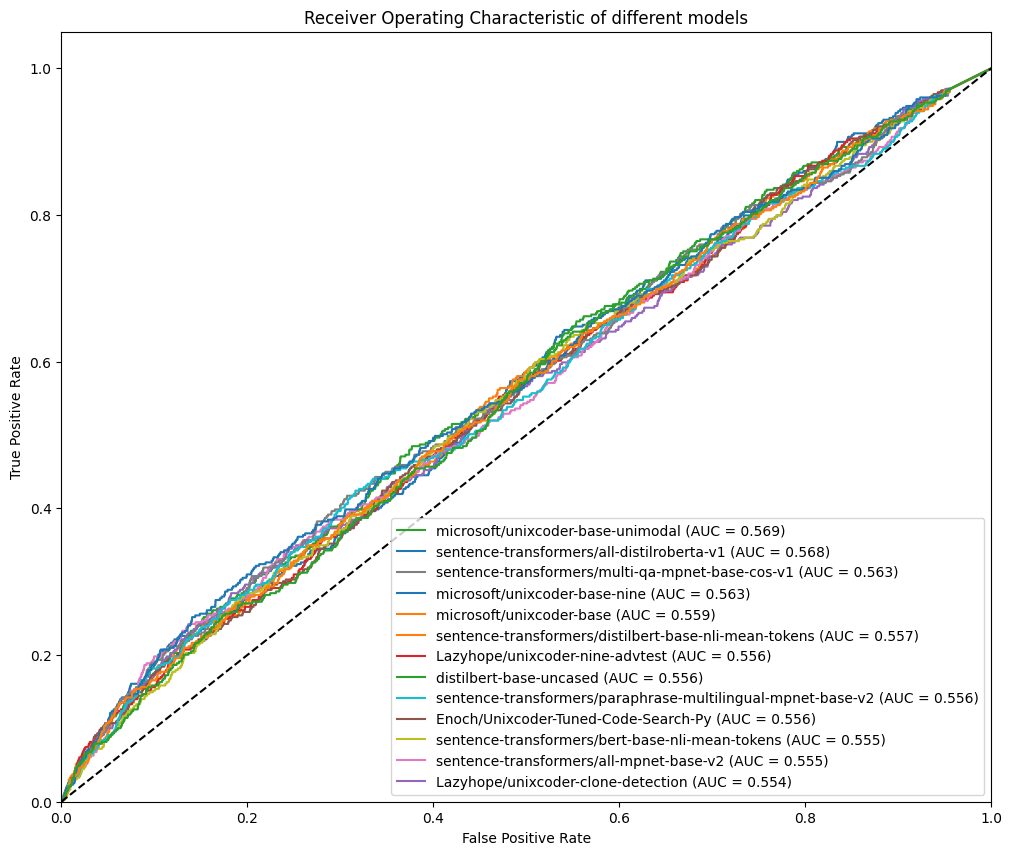

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))


def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc

    plt.plot(fpr, tpr, label=model_name)


for model in models:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_requirements_evaluation_train_315.eps')
plt.show()

In [18]:
model_auc

{'microsoft/unixcoder-base-nine': 0.5627094352770525,
 'microsoft/unixcoder-base': 0.5593271854133437,
 'microsoft/unixcoder-base-unimodal': 0.5692358709431283,
 'Lazyhope/unixcoder-nine-advtest': 0.5561350016741033,
 'Lazyhope/unixcoder-clone-detection': 0.5537967009941065,
 'Enoch/Unixcoder-Tuned-Code-Search-Py': 0.5555663723268667,
 'sentence-transformers/all-mpnet-base-v2': 0.5548617844848416,
 'sentence-transformers/multi-qa-mpnet-base-cos-v1': 0.5634882665845828,
 'sentence-transformers/bert-base-nli-mean-tokens': 0.5550633805743339,
 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2': 0.5557310963014059,
 'sentence-transformers/all-distilroberta-v1': 0.567736832851262,
 'sentence-transformers/distilbert-base-nli-mean-tokens': 0.557320234532326,
 'distilbert-base-uncased': 0.5559872279368057}